__Visualized Transformer Attention with DINO__

Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [82]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import timm
import dino
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time
import urllib.request

device = torch.device("cpu")

Load ViT Model

In [61]:
#model = timm.create_model('vit_small_patch16_224_dino',pretrained=True)
model = torch.hub.load('facebookresearch/dino:main','dino_vits16')

Using cache found in C:\Users\bjohnson/.cache\torch\hub\facebookresearch_dino_main


Visualize attention

Load image:

In [110]:
# Setup frame capture
cap = cv2.VideoCapture('video2.mp4') #use video
# cap = cv2.VideoCapture(0) #stream from webcam
previous_frame = None

image = Image.open("img2.jpg")
Tx = transforms.Resize((800,800))(image)
Tx2 = transforms.ToTensor()(Tx).unsqueeze_(0)
Tx3 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(Tx2)
Tx3.requires_grad = True

print(Tx3.shape)

torch.Size([1, 3, 800, 800])


Feed network

In [111]:
model.eval()
model.to(device)

attentions = model.get_last_selfattention(Tx3)


print(Tx3.shape)
print(attentions.shape)

nh = attentions.shape[1]
attentions = attentions[0, :, 0, 1:].reshape(nh,-1)
print(attentions.shape)

val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)

patch_size = 8

w_featmap = Tx3.shape[-2] // patch_size
h_featmap = Tx3.shape[-1] // patch_size

threshold = 0.6 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
    
th_attn = th_attn.reshape(nh, w_featmap//2, h_featmap//2).float()

# interpolate
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().numpy()

attentions = attentions.reshape(nh, w_featmap//2, h_featmap//2)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().numpy()
attentions_mean = np.mean(attentions, axis=0)


torch.Size([1, 3, 800, 800])
torch.Size([1, 6, 2501, 2501])
torch.Size([6, 2500])


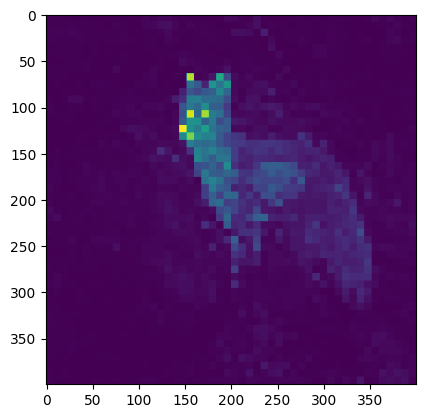

In [112]:
plt.imshow(attentions_mean)

In [ ]:
  
while True: 
    # Load frame
    ret,img = cap.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.addWeighted(img,1.5,img,0,1)

    # Compute depth
    input_batch = transform(img).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=(120, 160),
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    output = prediction.cpu().numpy()
    depth = cv2.normalize(output, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype = cv2.CV_64F)
    #depth = (depth).astype(np.uint8)

    if (previous_frame is None):
        # First frame; there is no previous one yet
        previous_frame = img
        continue
    # calculate difference and update previous frame
    diff_frame = cv2.absdiff(src1=previous_frame, src2=img)
    previous_frame = img
    # 4. Dilute the image a bit to make differences more seeable; more suitable for contour detection
    kernel = np.ones((5, 5))
    diff_frame = cv2.dilate(diff_frame, kernel, 1)
    # 5. Only take different areas that are different enough (>20 / 255)
    thresh_frame = cv2.threshold(src=diff_frame, thresh=100, maxval=255, type=cv2.THRESH_BINARY)[1]
    im = cv2.cvtColor(thresh_frame, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(image=im, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    mini = cv2.resize(depth, (6,4), interpolation = cv2.INTER_AREA)
    # Show frames
    cv2.namedWindow('Video',cv2.WINDOW_KEEPRATIO)
    cv2.imshow('Video',img)
    # cv2.namedWindow('Contrast',cv2.WINDOW_KEEPRATIO)
    # cv2.imshow('Contrast',img2)
    cv2.namedWindow('Mini',cv2.WINDOW_KEEPRATIO)
    cv2.imshow('Mini',depth)
    #cv2.drawContours(image=img, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    #cv2.imshow('thresh',thresh_frame)
    
    if(cv2.waitKey(10) & 0xFF == ord('b')):
        break